### **Fake News Detection**
Group No. - 14 <br>
Member 1: Sai Aakash Vydana<br>
Member 2: Devi Varaprasad Jonnala<br>




In [ ]:
!pip install datasets

In [ ]:
!pip install nltk

In [ ]:
from datasets import load_dataset

dataset = load_dataset("liar")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
import re
import nltk
import torch
import math
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple, List
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
nltk.download('stopwords')


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data = pd.DataFrame(dataset["train"])
test_data = pd.DataFrame(dataset["test"])
val_data = pd.DataFrame(dataset["validation"])

nb_train_samples = len(train_data)
nb_val_samples = len(val_data)
nb_test_samples = len(test_data)

nb_train_samples, nb_val_samples, nb_test_samples

(10269, 1284, 1283)

In [ ]:
columns_to_concat = ['statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'context']
columns_to_retain = ['label', 'combined_text', 'mostly_true_counts', 'barely_true_counts', 'half_true_counts', 'false_counts', 'pants_on_fire_counts']

def replace_missing(value):
    if value in [None, '', np.nan]:
        return 'none'
    return value


for dataset in [train_data, val_data, test_data]:
    dataset[dataset.columns[1:]] = dataset[dataset.columns[1:]].applymap(replace_missing)
    dataset['combined_text'] = dataset.apply(lambda x: ' '.join(x[col] for col in columns_to_concat if not pd.isnull(x[col])), axis=1)
    dataset.drop(columns=[col for col in dataset.columns if col not in columns_to_retain], inplace=True)

def transform_labels(label):
    # Merging categories 0, 1, 4, 5 into category 0 and categories 2, 3 into category 1
    if label in [2, 3]:
        return 1
    else:
        return 0

train_data['label'] = train_data['label'].apply(transform_labels)
val_data['label'] = val_data['label'].apply(transform_labels)
test_data['label'] = test_data['label'].apply(transform_labels)


In [ ]:
combined_data = pd.concat([train_data, val_data, test_data])
combined_data.shape

(12836, 7)

In [ ]:
# Preprocessing and cleaning the text data

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    required_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(required_tokens)

def preprocess(text):
    # Here we convert the text to lowercase
    text = text.lower()
    # Here we remove the @ and #
    text = re.sub(r'\@\w+|\#',' ', text)
    # Here we remove the punctutions
    text = re.sub(r'[^\w\s]', ' ', text)
    # Here we remove the numbers
    text = re.sub(r'\d+', '', text)
    # Here we remove the stop words
    text = remove_stopwords(text)
    return text

combined_data['combined_text'] = combined_data['combined_text'].apply(preprocess)
combined_data.head()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,combined_text
0,0,0.0,1.0,0.0,0.0,0.0,says annies list political group supports thir...
1,0,0.0,0.0,1.0,1.0,0.0,decline coal start started natural gas took st...
2,1,70.0,71.0,160.0,163.0,9.0,hillary clinton agrees john mccain voting give...
3,0,7.0,19.0,3.0,5.0,44.0,health care reform legislation likely mandate ...
4,0,15.0,9.0,20.0,19.0,2.0,economic turnaround started end term economy j...


In [ ]:
from collections import Counter

# The tokenize function to convert text to tokens
def tokenize(dataframe, text_column):

    def find_text(text):
        return re.findall(r'\b\w+\b', text)

    word_index = {}
    index_word = {}

    # Counting teh words using Counter
    word_counts = Counter()
    for text in dataframe[text_column]:
        words = find_text(text)
        word_counts.update(words)

    # Here we assign indices to words based on their frequency
    sorted_words = [word for word, _ in word_counts.most_common()]
    for i, word in enumerate(sorted_words):
        word_index[word] = i + 1

    # Tokenize text and convert it into indices based on the built word index
    def convert_to_indices(text):
        words = find_text(text)
        return [word_index.get(word, 0) for word in words]

    # Apply the conversion to all rows in the specified column of the dataframe
    dataframe['token'] = dataframe[text_column].apply(convert_to_indices)
    return dataframe,len(word_index)


combined_data, dataset_vocabulary_size = tokenize(combined_data, 'combined_text')

combined_data.head()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,combined_text,token
0,0,0.0,1.0,0.0,0.0,0.0,says annies list political group supports thir...,"[5, 6692, 890, 198, 270, 511, 451, 6693, 764, ..."
1,0,0.0,0.0,1.0,1.0,0.0,decline coal start started natural gas took st...,"[1988, 1066, 1040, 803, 996, 331, 264, 803, 20..."
2,1,70.0,71.0,160.0,163.0,9.0,hillary clinton agrees john mccain voting give...,"[78, 61, 4222, 51, 144, 145, 489, 215, 147, 13..."
3,0,7.0,19.0,3.0,5.0,44.0,health care reform legislation likely mandate ...,"[7, 11, 324, 407, 862, 863, 485, 621, 171, 550..."
4,0,15.0,9.0,20.0,19.0,2.0,economic turnaround started end term economy j...,"[346, 4770, 803, 528, 633, 19, 20, 291, 342, 1..."


In [ ]:
X_pad = pad_sequence([torch.tensor(tokens) for tokens in combined_data['token']], batch_first=True)

X_true_false_count = torch.tensor(combined_data[['mostly_true_counts', 'half_true_counts', 'barely_true_counts', 'false_counts', 'pants_on_fire_counts']].values, dtype=torch.float)

# Converting labels to PyTorch tensors
y_tensor = torch.squeeze(torch.tensor([item for item in combined_data.iloc[:, 0]]))


indices = list(range(len(combined_data)))
# Getting indices to split into
train_indices = indices[:nb_train_samples]
val_indices = indices[nb_train_samples:nb_train_samples+nb_val_samples]
test_indices = indices[nb_train_samples+nb_val_samples:nb_train_samples+nb_val_samples+nb_test_samples]

class StatementsDataset(Dataset):
    def __init__(self, X_pad, X_true_false_count, y_tensor, indices):
        self.X_pad = X_pad
        self.X_true_false_count = X_true_false_count
        # self.X_true_count = X_true_count
        self.y_tensor = y_tensor
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        inputs = (self.X_pad[index], self.X_true_false_count[index])
        label = self.y_tensor[index]
        return inputs, label

train_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, train_indices)
val_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, val_indices)
test_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, test_indices)

# Defining batch size
batch_size = 64

# Create data loaders for the pytorch datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)


In [ ]:
# Define hyperparameters for the CNN
embeddings = 128
num_filters = 3
filter_sizes = [2,3,4]
num_outputs = 2
dropout = 0.3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the CNN model
model = CNNModel(dataset_vocabulary_size + 1, embeddings, num_filters, filter_sizes, num_outputs, dropout)
model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
model

CNNModel(
  (embedding): Embedding(15446, 128)
  (convs): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(2, 128), stride=(1, 1))
    (1): Conv2d(1, 2, kernel_size=(3, 128), stride=(1, 1))
    (2): Conv2d(1, 2, kernel_size=(4, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=6, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Defining array to store training/validation accuracy and loss
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []


start = time.time()
epochs = 100
best_val_loss = float('inf')
patience = 3
patience_count =0

# training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    training_correct_pred = 0

    for inputs, labels in train_loader:
        inputs_list = [input.to(device) for input in inputs]
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs_list[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        _, predicted = torch.max(outputs.data, 1)
        training_correct_pred += (predicted == labels).sum().item()

    # Calculating the training accuracy and training loss
    train_loss /= len(train_loader.dataset)
    train_accuracy = training_correct_pred / len(train_loader.dataset)
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    model.eval()
    validation_loss = 0.0
    validation_correct_pred = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs_list = [input.to(device) for input in inputs]
            labels = labels.to(device)
            outputs = model(inputs_list[0])
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            validation_correct_pred += (predicted == labels).sum().item()

    # Calculating validation accuracy and validation loss
    validation_loss /= len(val_loader.dataset)
    validation_accuracy = validation_correct_pred / len(val_loader.dataset)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch + 1}: Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}, '
          f'Validation Accuracy: {validation_accuracy:.4f}, Validation Loss: {validation_loss:.4f}')

    if validation_loss < best_val_loss:
      best_val_loss = validation_loss
      patience_count =0
    else:
      patience_count +=1
      if patience_count >= patience:
        print("Early stopping due to lack of improvement in validation loss")
        break

finish = time.time()
print("Time taken to train the model: ", finish - start,'s')

Epoch 1: Training Accuracy: 0.6290, Training Loss: 0.0106, Validation Accuracy: 0.6698, Validation Loss: 0.0100
Epoch 2: Training Accuracy: 0.6641, Training Loss: 0.0096, Validation Accuracy: 0.6815, Validation Loss: 0.0099
Epoch 3: Training Accuracy: 0.7002, Training Loss: 0.0090, Validation Accuracy: 0.6682, Validation Loss: 0.0099
Epoch 4: Training Accuracy: 0.7403, Training Loss: 0.0082, Validation Accuracy: 0.6760, Validation Loss: 0.0103
Epoch 5: Training Accuracy: 0.7881, Training Loss: 0.0071, Validation Accuracy: 0.6721, Validation Loss: 0.0114
Epoch 6: Training Accuracy: 0.8288, Training Loss: 0.0061, Validation Accuracy: 0.6558, Validation Loss: 0.0122
Early stopping due to lack of improvement in validation loss
Time taken to train the model:  8.478480100631714 s


In [ ]:
# Model evaluation on the test dataset
model.eval()
test_predictions = []
test_labels = []
testing_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs_list = [input.to(device) for input in inputs]
        labels = labels.to(device)

        outputs = model(inputs_list[0])
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)1
        testing_loss += loss.item()

        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions)
testing_loss = testing_loss/len(test_loader.dataset)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {testing_loss}")
print("Classification Report: ")
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.5923616523772408
Test Loss: 0.01327991636581748
Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       823
           1       0.43      0.42      0.42       460

    accuracy                           0.59      1283
   macro avg       0.55      0.55      0.55      1283
weighted avg       0.59      0.59      0.59      1283



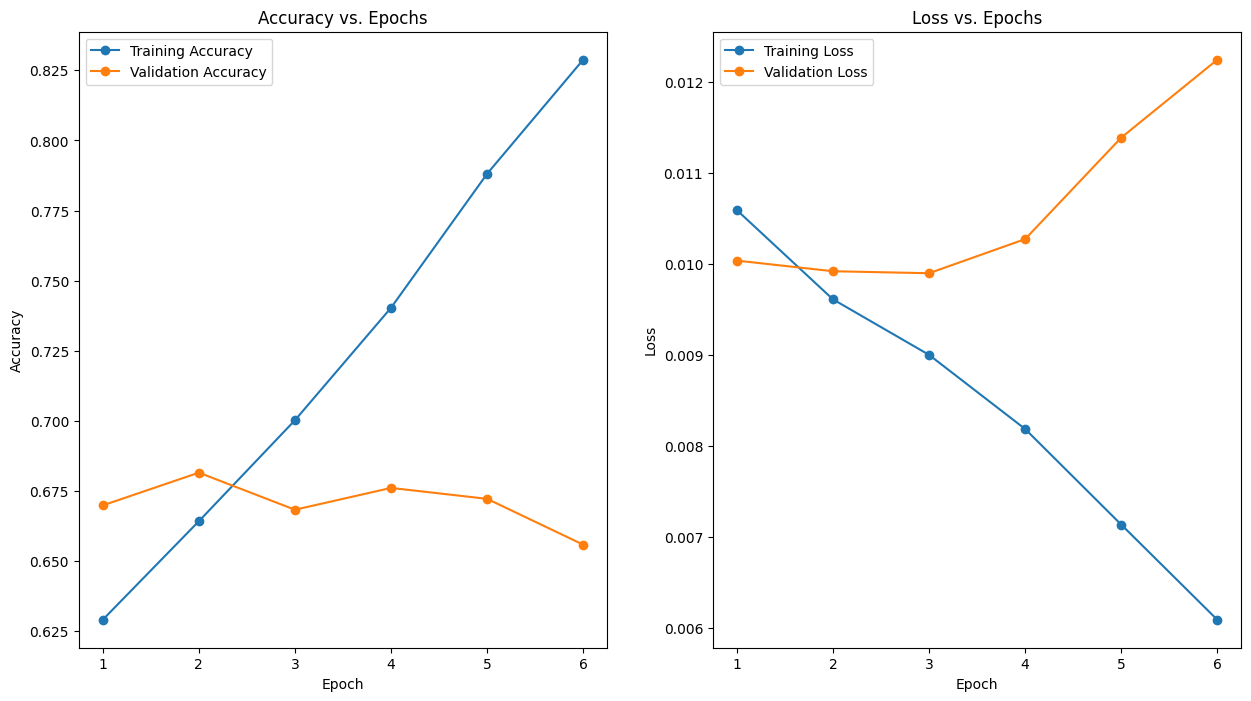

In [ ]:
epochs = range(1, len(training_accuracies) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].plot(epochs, training_accuracies, label='Training Accuracy', marker='o')
axs[0].plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o')
axs[0].set_title('Accuracy vs. Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()


axs[1].plot(epochs, training_losses, label='Training Loss', marker='o')
axs[1].plot(epochs, validation_losses, label='Validation Loss', marker='o')
axs[1].set_title('Loss vs. Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()